In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [62]:
# ======== 1. Đọc và xử lý dữ liệu ========
df = pd.read_csv("Gold_Futures_Cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

data = df[['Date', 'Price']].copy()

# Chia 80% train, 20% test theo thời gian (lùi 60 bước cho test)
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index - 60:]

# Chuẩn hóa
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[['Price']])
scaled_test = scaler.transform(test_data[['Price']])

# Tạo chuỗi thời gian
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

# Ngày tương ứng để vẽ
train_dates = train_data['Date'].iloc[seq_length:].reset_index(drop=True)
test_dates = test_data['Date'].iloc[seq_length:].reset_index(drop=True)

In [63]:
# ======== 2. Xây dựng mô hình GRU ========
model = Sequential()
model.add(GRU(64, return_sequences=False, input_shape=(seq_length, 1),
                kernel_regularizer=regularizers.l2(0.001))) # Thêm L2 regularization

model.add(Dropout(0.2))  # Thêm Dropout để giảm overfit
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\admin\anaconda3\envs\gru-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
# ======== 3. Callbacks để giảm overfit ========
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

In [65]:
# ======== 4. Huấn luyện mô hình ========
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=1,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
2450/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 1: val_loss improved from inf to 0.00211, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0063 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 2: val_loss improved from 0.00211 to 0.00128, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0015 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 3/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 3: val_loss improved from 0.00128 to 0.00078, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.0012 - val_loss: 7.7840e-04 - learning_rate: 0.0010
Epoch 4/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4047e-04
Epoch 4: val_loss improved from 0.00078 to 0.00077, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.4055e-04 - val_loss: 7.6552e-04 - learning_rate: 0.0010
Epoch 5/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 5: val_loss did not improve from 0.00077
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.0011 - val_loss: 7.9028e-04 - learning_rate: 0.0010
Epoch 6/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4460e-04
Epoch 6: val_loss did not improve from 0.00077
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 9.4458e-04 - val_loss: 7.9355e-04 - learning_rate: 0.0010
Epoch 7/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1546e-04
Epoch 7: val_loss improved from 0.00077 to 0.00070, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.1547e-04 - val_loss: 6.9923e-04 - learning_rate: 0.0010
Epoch 8/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.9740e-04
Epoch 8: val_loss did not improve from 0.00070
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 8.9730e-04 - val_loss: 7.6885e-04 - learning_rate: 0.0010
Epoch 9/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7141e-04
Epoch 9: val_loss did not improve from 0.00070
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 8.7141e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 10/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1028e-04
Epoch 10: val_loss did not improve from 0.00070
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 8.1029e-04 - val_loss: 8.1338e-04 - learning_rate: 0.0010
Epoch 11/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5927e-04
Epoch 11: val_loss improved from 0.00070 to 0.00062, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 7.5934e-04 - val_loss: 6.2018e-04 - learning_rate: 0.0010
Epoch 12/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2279e-04
Epoch 12: val_loss did not improve from 0.00062
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 8.2278e-04 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 13/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1823e-04
Epoch 13: val_loss did not improve from 0.00062
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 8.1823e-04 - val_loss: 7.8085e-04 - learning_rate: 0.0010
Epoch 14/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9501e-04
Epoch 14: val_loss did not improve from 0.00062
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 7.9504e-04 - val_loss: 6.7780e-04 - learning_rate: 0.0010
Epoch 15/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7663e-04
Epoch 15: val_loss did not improve from 0.00062
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 7.7670e-04 - va

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 6.2931e-04 - val_loss: 5.9373e-04 - learning_rate: 5.0000e-04
Epoch 24/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5096e-04
Epoch 24: val_loss improved from 0.00059 to 0.00055, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 6.5088e-04 - val_loss: 5.4927e-04 - learning_rate: 5.0000e-04
Epoch 25/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8385e-04
Epoch 25: val_loss did not improve from 0.00055
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.8388e-04 - val_loss: 7.0326e-04 - learning_rate: 5.0000e-04
Epoch 26/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3885e-04
Epoch 26: val_loss did not improve from 0.00055
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 5.3887e-04 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 27/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7874e-04
Epoch 27: val_loss did not improve from 0.00055
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.7873e-04 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 28/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8973e-04
Epoch 28: val_loss did not improve from 0.00055
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.8


Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 5.6633e-04 - val_loss: 5.2469e-04 - learning_rate: 5.0000e-04
Epoch 32/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9787e-04
Epoch 32: val_loss did not improve from 0.00052
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.9763e-04 - val_loss: 6.6088e-04 - learning_rate: 2.5000e-04
Epoch 33/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8925e-04
Epoch 33: val_loss did not improve from 0.00052
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.8927e-04 - val_loss: 6.3940e-04 - learning_rate: 2.5000e-04
Epoch 34/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8606e-04
Epoch 34: val_loss did not improve from 0.00052
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.8610e-04 - val_loss: 5.6019e-04 - learning_rate: 2.5000e-04
Epoch 35/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6099e-04
Epoch 35: val_loss

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 5.0217e-04 - val_loss: 5.1445e-04 - learning_rate: 2.5000e-04
Epoch 41/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2376e-04
Epoch 41: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.2373e-04 - val_loss: 6.5306e-04 - learning_rate: 2.5000e-04
Epoch 42/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4995e-04
Epoch 42: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.4986e-04 - val_loss: 5.3882e-04 - learning_rate: 2.5000e-04
Epoch 43/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6529e-04
Epoch 43: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.6529e-04 - val_loss: 6.8148e-04 - learning_rate: 2.5000e-04
Epoch 44/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6425e-04
Epoch 44: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - l

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.4471e-04 - val_loss: 5.0688e-04 - learning_rate: 2.5000e-04
Epoch 46/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7610e-04
Epoch 46: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.7613e-04 - val_loss: 7.2652e-04 - learning_rate: 2.5000e-04
Epoch 47/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9591e-04
Epoch 47: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.9591e-04 - val_loss: 5.7679e-04 - learning_rate: 2.5000e-04
Epoch 48/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0286e-04
Epoch 48: val_loss did not improve from 0.00051
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.0280e-04 - val_loss: 6.5930e-04 - learning_rate: 2.5000e-04
Epoch 49/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9572e-04
Epoch 49: val_loss improved from 0.00051 to 0.00049, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.9572e-04 - val_loss: 4.9132e-04 - learning_rate: 2.5000e-04
Epoch 50/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1805e-04
Epoch 50: val_loss did not improve from 0.00049

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.1798e-04 - val_loss: 0.0011 - learning_rate: 2.5000e-04
Epoch 51/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4537e-04
Epoch 51: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.4539e-04 - val_loss: 7.2267e-04 - learning_rate: 1.2500e-04
Epoch 52/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5466e-04
Epoch 52: val_loss improved from 0.00049 to 0.00049, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.5465e-04 - val_loss: 4.8920e-04 - learning_rate: 1.2500e-04
Epoch 53/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5709e-04
Epoch 53: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.5708e-04 - val_loss: 6.6055e-04 - learning_rate: 1.2500e-04
Epoch 54/100
2455/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5118e-04
Epoch 54: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.5118e-04 - val_loss: 5.4826e-04 - learning_rate: 1.2500e-04
Epoch 55/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6945e-04
Epoch 55: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.6944e-04 - val_loss: 4.9960e-04 - learning_rate: 1.2500e-04
Epoch 56/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5988e-04
Epoch 56: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - l

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 5.1279e-04 - val_loss: 4.8650e-04 - learning_rate: 1.2500e-04
Epoch 58/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4761e-04
Epoch 58: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.4759e-04 - val_loss: 6.2955e-04 - learning_rate: 1.2500e-04
Epoch 59/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5558e-04
Epoch 59: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.5554e-04 - val_loss: 4.9693e-04 - learning_rate: 1.2500e-04
Epoch 60/100
2453/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7278e-04
Epoch 60: val_loss did not improve from 0.00049

Epoch 60: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 4.7274e-04 - val_loss: 0.0010 - learning_rate: 1.2500e-04
Epoch 61/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0135e-04
Epoch 61: val_loss impr

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.0136e-04 - val_loss: 4.8553e-04 - learning_rate: 6.2500e-05
Epoch 62/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1118e-04
Epoch 62: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.1119e-04 - val_loss: 5.9357e-04 - learning_rate: 6.2500e-05
Epoch 63/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4422e-04
Epoch 63: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.4419e-04 - val_loss: 5.4383e-04 - learning_rate: 6.2500e-05
Epoch 64/100
2452/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7362e-04
Epoch 64: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.7348e-04 - val_loss: 5.1251e-04 - learning_rate: 6.2500e-05
Epoch 65/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9748e-04
Epoch 65: val_loss did not improve from 0.00049
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - l

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.2987e-04 - val_loss: 4.8204e-04 - learning_rate: 6.2500e-05
Epoch 68/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1804e-04
Epoch 68: val_loss did not improve from 0.00048
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.1805e-04 - val_loss: 5.4127e-04 - learning_rate: 6.2500e-05
Epoch 69/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3876e-04
Epoch 69: val_loss did not improve from 0.00048
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.3868e-04 - val_loss: 5.4868e-04 - learning_rate: 6.2500e-05
Epoch 70/100
2454/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1732e-04
Epoch 70: val_loss improved from 0.00048 to 0.00048, saving model to best_model.h5



Epoch 70: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.1731e-04 - val_loss: 4.7985e-04 - learning_rate: 6.2500e-05
Epoch 71/100
2456/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1638e-04
Epoch 71: val_loss improved from 0.00048 to 0.00048, saving model to best_model.h5


2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.1638e-04 - val_loss: 4.7876e-04 - learning_rate: 3.1250e-05
Epoch 72/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2600e-04
Epoch 72: val_loss did not improve from 0.00048
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 4.2599e-04 - val_loss: 5.2273e-04 - learning_rate: 3.1250e-05
Epoch 73/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8547e-04
Epoch 73: val_loss did not improve from 0.00048
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 3.8547e-04 - val_loss: 4.8942e-04 - learning_rate: 3.1250e-05
Epoch 74/100
2451/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8987e-04
Epoch 74: val_loss did not improve from 0.00048
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 3.8994e-04 - val_loss: 6.7928e-04 - learning_rate: 3.1250e-05
Epoch 75/100
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9845e-04
Epoch 75: val_loss did not improve from 0.00048
2457/2457 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - l

In [ ]:
# ======== 5. Dự đoán ========
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)
train_inv = scaler.inverse_transform(y_train)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [67]:
# ======== 6. Đánh giá ========
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2 Score:", r2)

MAE: 40.53964425935904
MAPE: 1.5895026073168068
RMSE: 65.21724430206967
R2 Score: 0.9763043317022789


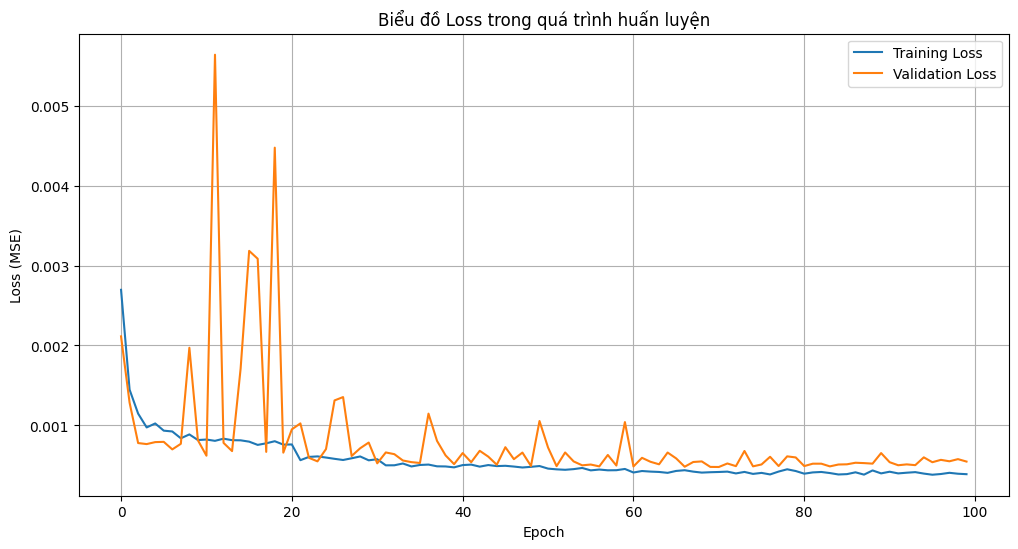

In [68]:
# ======== 7. Vẽ biểu đồ Loss ========
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

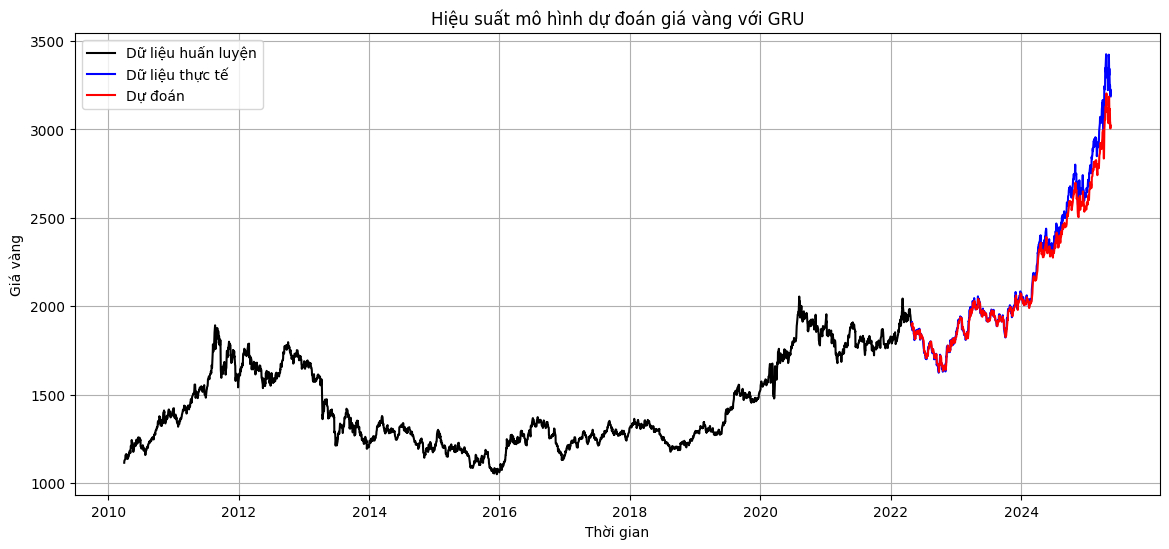

In [69]:
# ======== 8. Vẽ biểu đồ dự đoán ========
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_inv, label='Dữ liệu huấn luyện', color='black')
plt.plot(test_dates, y_test_inv, label='Dữ liệu thực tế', color='blue')
plt.plot(test_dates, y_pred_inv, label='Dự đoán', color='red')
plt.title('Hiệu suất mô hình dự đoán giá vàng với GRU')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.legend()
plt.grid()

years = pd.to_datetime([f'{y}-01-01' for y in range(2010, 2026, 2)])
plt.xticks(ticks=years, labels=[str(y.year) for y in years])
plt.show()